In [1]:
import numpy as np
import tensorflow as tf
import keras
import PIL
from keras.applications.vgg19 import preprocess_input
from matplotlib.pyplot import imshow
%matplotlib inline

Using TensorFlow backend.


In [2]:
VGG = keras.applications.vgg19.VGG19()

W0102 23:54:43.230008 4534506944 deprecation_wrapper.py:119] From /Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0102 23:54:43.246083 4534506944 deprecation_wrapper.py:119] From /Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0102 23:54:43.249072 4534506944 deprecation_wrapper.py:119] From /Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0102 23:54:43.280026 4534506944 deprecation_wrapper.py:119] From /Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:39

In [3]:
VGG.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [4]:
a_l = keras.Model(inputs=VGG.input, outputs=VGG.get_layer("block4_conv2").output)

## Content Image: Chicago Cityline

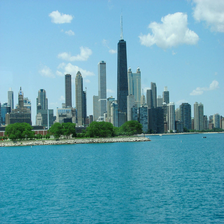

In [5]:
img = PIL.Image.open("/Users/zetong/Desktop/chicago.jpg")
img = img.resize((224, 224), PIL.Image.ANTIALIAS)
content = np.expand_dims(preprocess_input(np.asarray(img, dtype="int32")), axis=0)
img

## Style image: The Scream

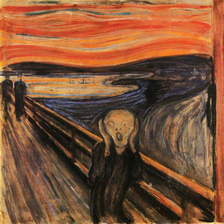

In [6]:
img2 = PIL.Image.open("/Users/zetong/Desktop/scream.jpg")
img2 = img2.resize((224, 224), PIL.Image.ANTIALIAS)
style = np.expand_dims(preprocess_input(np.asarray(img2, dtype="int32")), axis=0)
img2

In [7]:
print(content.shape, style.shape)
print(type(content), type(style))

(1, 224, 224, 3) (1, 224, 224, 3)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>


In [8]:
def generate_noise_image(content_image, noise_ratio = 0.6):
    noise_image = np.random.uniform(-20, 20, (1, 224, 224, 3))
    input_image = noise_image * noise_ratio + content_image * (1 - noise_ratio)
    input_image = tf.convert_to_tensor(input_image, dtype="float32")
    return input_image

In [9]:
# calculate the content loss based on the reshaped and normalized Content img tensor and Generated img tensor
# C, G both of shape (1, 224, 224, 3)
def J_content(C, G, model):
    a_C = model(C)
    a_G = model(G)
    m, n_H, n_W, n_C = a_C.get_shape().as_list()
    print(m, n_H, n_W, n_C)
    a_C_unrolled = tf.reshape(a_C, shape=[m, n_H * n_W, n_C])
    a_G_unrolled = tf.reshape(a_G, shape=[m, n_H * n_W, n_C])
    print(tf.reduce_sum(tf.square(tf.subtract(a_C_unrolled, a_G_unrolled))))
    content_loss = 1/(4*n_H*n_W*n_C) * tf.reduce_sum(tf.square(tf.subtract(a_C_unrolled, a_G_unrolled)))
    return content_loss

In [10]:
# calculate the content loss based on the reshaped and normalized Style img tensor and Generated img tensor
# C, G both of shape (1, 224, 224, 3)
def J_style(S, G, model):
    J = 0
    lamb = 1/len(model.layers)
    for layer in model.layers[1:]:
        m = keras.Model(inputs=VGG.input, outputs=layer.output)
        a_S = m(S)
        a_G = m(G)
        # only add activations in convolution layers
        if len(a_S.shape) != 4:
            break
        m, n_H, n_W, n_C = a_S.get_shape().as_list()
        a_S_unrolled = tf.transpose(tf.reshape(a_S, shape=[n_H * n_W, n_C]))
        a_G_unrolled = tf.transpose(tf.reshape(a_G, shape=[n_H * n_W, n_C]))
        GS = tf.matmul(a_S_unrolled, tf.transpose(a_S_unrolled))
        GG = tf.matmul(a_G_unrolled, tf.transpose(a_G_unrolled))
        J_style_layer = 1/(4*(n_C**2)*(n_H*n_W)**2) * tf.reduce_sum(tf.square(tf.subtract(GS, GG)))
        J += lamb*J_style_layer
    return J

In [11]:
noise = generate_noise_image(content)
G = tf.Variable(initial_value = noise)
content = tf.convert_to_tensor(content)
style = tf.convert_to_tensor(style)
J_C = J_content(content, G, a_l)
J_S = J_style(style, G, VGG)
J = 10*J_C + 40*J_S

1 28 28 512
Tensor("Sum:0", shape=(), dtype=float32)


In [12]:
training_op = tf.train.AdamOptimizer(2).minimize(J, var_list=[G])
sess = tf.InteractiveSession()
init = tf.global_variables_initializer()
X1, C = [],[]
sess.run(init)
n_iter = 100

for i in range(n_iter):
    _=sess.run(training_op)
    print(sess.run(J))
    generated = sess.run(G)
    generated = generated + np.array([123.68, 116.779, 103.939]).reshape((1,1,1,3)) 
    temp_img = PIL.Image.fromarray(np.uint8(generated[0]),'RGB')
    temp_img.save("/Users/zetong/Desktop/img/"+str(i)+".jpg")
    X1.append(sess.run(G))
    C.append(sess.run(J))

5459.9746
5337.088
5208.821
5073.5156
4930.508
4779.802
4621.832
4457.415
4287.895
4114.6543
3939.365
3763.5906
3588.5828
3415.239
3244.0425
3075.264
2909.1167
2745.7715
2585.6714
2429.3857
2277.282
2129.6794
1986.8866
1848.9592
1715.8121
1587.377
1463.5236
1344.1051
1229.0062
1118.2672
1011.98315
910.3482
813.7133
722.377
636.653
556.8543
483.2543
416.07156
355.4233
301.3012
253.58443
212.04733
176.40948
146.30704
121.25315
100.74241
84.23262
71.156006
60.99388
53.226955
47.37892
43.028233
39.794388
37.35135
35.43277
33.835136
32.40365
31.031654
29.64906
28.216219
26.722925
25.174755
23.591938
22.006441
20.451284
18.962358
17.571098
16.30367
15.178609
14.206433
13.388833
12.71905
12.183473
11.763549
11.436512
11.178825
10.96756
10.781911
10.604328
10.4210825
10.2225065
10.003108
9.760833
9.496765
9.214257
8.918721
8.616559
8.314905
8.020583
7.7397537
7.4773827
7.23678
7.019477
6.8254776
6.65316
6.4997725
6.3618836
6.2357445
6.1178713
6.005196


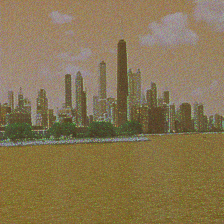

In [26]:
generated = X1[-1]
generated = generated + np.array([123.68, 116.779, 103.939]).reshape((1,1,1,3)) 
PIL.Image.fromarray(np.uint8(generated[0]),'RGB')